# Kaggle House Prices

## Initialization & utility functions

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn import model_selection as ms
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor, RidgeCV, ElasticNetCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor

from pandas.api.types import CategoricalDtype

In [2]:
df_train_raw = pd.read_csv('train.csv', index_col=0)
df_test_raw = pd.read_csv('test.csv', index_col=0)
df_train = df_train_raw.copy()
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# create ordinal mappings

qualMapping = {'NA':-1, 'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}
expMapping = {'NA':-1, 'No':0, 'Mn':1, 'Av':2, 'Gd':3}
bsmtMapping = {'GLQ':5,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'NA':0}
finishMapping = {'NA':-1, 'Unf':0, 'RFn':1, 'Fin':2}
pvmtMapping = {'N':-1, 'P':0, 'Y':2}

mappings = {}
mappings['ExterQual'] = qualMapping
mappings['ExterCond'] = qualMapping
mappings['BsmtExposure'] = expMapping
mappings['BsmtFinType1'] = bsmtMapping
mappings['BsmtFinType2'] = bsmtMapping
mappings['BsmtQual'] = qualMapping
mappings['BsmtCond'] = qualMapping
mappings['HeatingQC'] = qualMapping
mappings['KitchenQual'] = 

mappings['FireplaceQu'] = qualMapping
mappings['GarageFinish'] = finishMapping
mappings['GarageQual'] = qualMapping
mappings['GarageCond'] = qualMapping
mappings['PavedDrive'] = pvmtMapping
mappings['PoolQC'] = qualMapping


In [25]:
# drop redundant or useless columns
uselessColumns = set(["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "1stFlrSF", "2ndFlrSF",'Condition1', 'Condition2'])

oneHotCategoryColumns = set(["MSSubClass", "MSZoning", "Street", "Alley", "LotShape", "LandContour",
                            "LotConfig", "LandSlope", "Neighborhood", "HouseStyle", "RoofStyle",
                            "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation",
                            "Heating", "CentralAir", "Electrical", "GarageType", "PavedDrive",
                            "SaleType", "SaleCondition", "BldgType", "Fence", "Functional"])

ordinalCategoryColumns = set(["ExterQual", "ExterCond", "BsmtQual",
                            "BsmtCond", "BsmtExposure", "BsmtFinType2", "HeatingQC", "KitchenQual",
                            "FireplaceQu", "GarageFinish", "GarageQual", "GarageCond", "PoolQC",
                            "BsmtFinType1"])

numericCategoryColumns = set(["OverallQual", "OverallCond", "GarageCars", "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath"])

specificOneHotColumns = set(["Utilities", "Condition1", "Condition2", "MiscFeature", "PoolArea", "Neighborhood"])

numericColumns = set(["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2",
                    "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF",
                    "GrLivArea", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces",
                    "GarageYrBlt", "GarageArea", "WoodDeckSF", "OpenPorchSF",
                    "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal"])

dateTimeColumns = set(["YearBuilt", "YearRemodAdd", 'DateSold'])

from numbers import Number
def cleanData(dataframe, verbose=False, dropUseless=True):
    df = dataframe.copy()
    for col in df.columns:
        if verbose : print(col.ljust(15), str(df[col].dtype).ljust(10), end="")
        if dataframe[col].dtype in (int, float):
            if verbose : print(": Numeric, add missing values")
            df.loc[:, col] = (df[col] - df[col].mean()) / df[col].std()
            df.loc[:, col] = df[col].interpolate(method='akima')

        else :
            if verbose : print(": Not a number, fill with None")
            df[col].fillna("None", inplace=True)
    return df

def preprocessData(dataframe, verbose=False, dropUseless=True):
    df = dataframe.copy()
    # modify date column
    if 'YrSold' in df.columns and 'MoSold' in df.columns:
        df.loc[:, 'DateSold'] = df['YrSold'] + df['MoSold'] / 12.0
        df.drop(['YrSold', 'MoSold'], inplace=True, axis=1)

    # convert one-hot columns
    for col in df.columns:
        if verbose : print(col.ljust(15), str(df[col].dtype).ljust(10), end="")
        if col == "SalePrice":
            if verbose : print(": Target feature, Don't change it!!!")
        
        # create category
        elif col in ordinalCategoryColumns:
            if verbose : print(": Categorical, convert to category codes")
                
            catList = list(mappings[col].keys())
            catType = CategoricalDtype(categories=catList, ordered=True)
            df.loc[:, col] = df[col].astype(catType)
            df[col + "Code"] = df[col].cat.codes
            df.drop(col, axis=1, inplace=True)
                
#            df.loc[:, col] = df[col].fillna('None')
#            df.loc[:, col] = df[col].astype('category')
#            df[col + "Code"] = df[col].cat.codes
#            df.drop(col, axis=1, inplace=True)

        elif col in numericCategoryColumns:
            if verbose : print(": Categorical as numeric, don't change anything")
 
        # one hot encoding
        elif col in oneHotCategoryColumns:
            if verbose : print(": One-Hot, generate one-hot encoding")
            df = pd.concat([df,pd.get_dummies(df[col], prefix=col, prefix_sep="=")],axis=1)
            df.drop(col, axis=1, inplace=True)

        # numeric values, nothing to do
        elif col in numericColumns:
            if verbose : print(": Numeric, add missing values, nothing more to do")
            df.loc[:, col] = (df[col] - df[col].mean()) / df[col].std()
            df.loc[:, col] = df[col].interpolate(method='akima')

        elif col in specificOneHotColumns:
        # specific columns
            if col == "MiscFeature":
                if verbose : print(": Misc Feature, one-hot encoding")
                df[col].fillna("None", inplace=True)
                df = pd.concat([df,pd.get_dummies(df[col], prefix=col, prefix_sep="=")],axis=1)
                df.drop(col, axis=1, inplace=True)

            # specific colum, only 2 values so kept as a boolean column
            elif col == "Utilities":  #'AllPub', 'NoSeWa' just boolean
                if verbose : print(": Utilities, only 2 values, convert to boolean")
                df[col].fillna("None")
                df = pd.concat([df,pd.get_dummies(df[col], prefix=col, prefix_sep="=")],axis=1)
                df.drop(col, axis=1, inplace=True)
            
            elif col == "PoolArea":
                df[col].fillna(0.0)
                df["HasPool"] = df[col] > 0.0            

        elif col in dateTimeColumns:
            if verbose : print(": Datetime, keep as float for regression")
        else:
            if verbose : print(": UNKNOWN")

    # drop useless columns
    if dropUseless : df.drop(uselessColumns, axis=1, inplace=True)
    return df

df_train = df_train_raw.copy()
df_train = preprocessData(df_train, verbose = True)
df_train.head()

MSSubClass      int64     : One-Hot, generate one-hot encoding
MSZoning        object    : One-Hot, generate one-hot encoding
LotFrontage     float64   : Numeric, add missing values, nothing more to do
LotArea         int64     : Numeric, add missing values, nothing more to do
Street          object    : One-Hot, generate one-hot encoding
Alley           object    : One-Hot, generate one-hot encoding
LotShape        object    : One-Hot, generate one-hot encoding
LandContour     object    : One-Hot, generate one-hot encoding
Utilities       object    : Utilities, only 2 values, convert to boolean
LotConfig       object    : One-Hot, generate one-hot encoding
LandSlope       object    : One-Hot, generate one-hot encoding
Neighborhood    object    : One-Hot, generate one-hot encoding
Condition1      object    Condition2      object    BldgType        object    : One-Hot, generate one-hot encoding
HouseStyle      object    : One-Hot, generate one-hot encoding
OverallQual     int64     : Ca

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,LowQualFinSF,GrLivArea,...,SaleType=ConLw,SaleType=New,SaleType=Oth,SaleType=WD,SaleCondition=Abnorml,SaleCondition=AdjLand,SaleCondition=Alloca,SaleCondition=Family,SaleCondition=Normal,SaleCondition=Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,-0.207948,-0.207071,7,5,2003,2003,0.509840,-0.459145,-0.120201,0.370207,...,0,0,0,1,0,0,0,0,1,0
2,0.409724,-0.091855,6,8,1976,1976,-0.572637,0.466305,-0.120201,-0.482347,...,0,0,0,1,0,0,0,0,1,0
3,-0.084413,0.073455,7,5,2001,2002,0.322063,-0.313261,-0.120201,0.514836,...,0,0,0,1,0,0,0,0,1,0
4,-0.413838,-0.096864,7,5,1915,1970,-0.572637,-0.687089,-0.120201,0.383528,...,0,0,0,1,1,0,0,0,0,0
5,0.574436,0.375020,8,5,2000,2000,1.360357,0.199611,-0.120201,1.298881,...,0,0,0,1,0,0,0,0,1,0


In [18]:
def testModels(dataframe, features, targetFeature):
    models = [LinearRegression(),
              RidgeCV(alphas=[0.1, 1.0, 10.0]),
              Lasso(alpha=1.0),
              ElasticNetCV(cv=5),
              #SGDRegressor(max_iter=5, tol=None),
              #GaussianNB(),
              DecisionTreeRegressor(),
              GradientBoostingRegressor(learning_rate=0.1, n_estimators = 100),
              RandomForestRegressor()]

    # preparing X and Y before split
    X_all = dataframe[features]
    Y_all = dataframe[targetFeature]
    X_train, X_valid, Y_train, Y_valid = ms.train_test_split(X_all, Y_all, test_size=0.20)

    modelScores = {}
    for i, mod in enumerate(models):
        # cross validation
        scores = ms.cross_val_score(mod, X_all, Y_all, cv=5)
        print(mod.__class__.__name__.ljust(30), scores,"Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))                                         
        modelScores[mod] = scores.mean()
        
    bestModel = max(modelScores, key=lambda k: modelScores[k])
    bestAccuracy = max(modelScores.values())

    #definitively fit the model on the train data
    bestModel.fit(X_all, Y_all)
    return bestModel, bestAccuracy
    
bestModel, bestAccuracy = testModels(df_train, ['GrLivArea', 'TotalBsmtSF', 'OverallQual'], 'SalePrice')

LinearRegression               [0.78658694 0.75766871 0.759937   0.74717044 0.61176451] Accuracy: 0.73 (+/- 0.12)
RidgeCV                        [0.78642301 0.7578579  0.75916488 0.74739219 0.61350233] Accuracy: 0.73 (+/- 0.12)
Lasso                          [0.78658595 0.7576691  0.75993226 0.74717046 0.61177336] Accuracy: 0.73 (+/- 0.12)
ElasticNetCV                   [0.04708509 0.04650564 0.03840331 0.03073902 0.04395478] Accuracy: 0.04 (+/- 0.01)
DecisionTreeRegressor          [0.64947056 0.55881725 0.76864176 0.73580699 0.69095963] Accuracy: 0.68 (+/- 0.15)
GradientBoostingRegressor      [0.78943192 0.71356785 0.85764907 0.82375851 0.83762926] Accuracy: 0.80 (+/- 0.10)
RandomForestRegressor          [0.77519241 0.67696152 0.82765136 0.80364818 0.76909795] Accuracy: 0.77 (+/- 0.10)


In [19]:
def submit(model, df, features, submissionName):
    y_pred = model.predict(df[features])
    df_submission = pd.DataFrame(index=df.index)
    df_submission['SalePrice'] = y_pred
    df_submission.to_csv('submission.csv', header=True)
    df_submission.head()
    #!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m str(submissionName)

## Test Models 1 (3 columns)

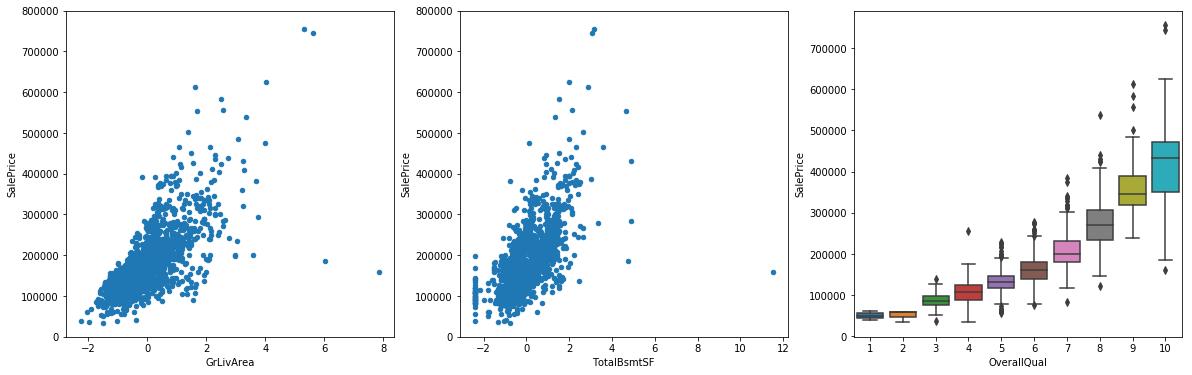

In [20]:
fig, axes = plt.subplots(figsize=(20, 6), nrows=1, ncols=3)
#scatter plot grlivarea/saleprice
data = pd.concat([df_train['SalePrice'], df_train['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000),ax=axes[0])

#scatter plot totalbsmtsf/saleprice
data = pd.concat([df_train['SalePrice'], df_train['TotalBsmtSF']], axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice', ylim=(0,800000),ax=axes[1]);

#box plot overallqual/saleprice
data = pd.concat([df_train['SalePrice'], df_train['OverallQual']], axis=1)
fig = sb.boxplot(x='OverallQual', y="SalePrice", data=data, ax=axes[2])


In [26]:
simplestFeatures = ['GrLivArea', 'OverallQual', "TotalBsmtSF"]
className = 'SalePrice'

testModels(df_train, simplestFeatures, className)

LinearRegression               [0.78658694 0.75766871 0.759937   0.74717044 0.61176451] Accuracy: 0.73 (+/- 0.12)
RidgeCV                        [0.78642301 0.7578579  0.75916488 0.74739219 0.61350233] Accuracy: 0.73 (+/- 0.12)
Lasso                          [0.78658595 0.7576691  0.75993228 0.7471705  0.61177299] Accuracy: 0.73 (+/- 0.12)
ElasticNetCV                   [0.04708509 0.04650564 0.03840331 0.03073902 0.04395478] Accuracy: 0.04 (+/- 0.01)
DecisionTreeRegressor          [0.63390064 0.55490345 0.76491829 0.74973775 0.69499348] Accuracy: 0.68 (+/- 0.16)
GradientBoostingRegressor      [0.78885661 0.71303187 0.8576622  0.82342923 0.83733468] Accuracy: 0.80 (+/- 0.10)
RandomForestRegressor          [0.77114352 0.7356862  0.81502894 0.80971169 0.81028674] Accuracy: 0.79 (+/- 0.06)


(GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False), 0.8040629186153568)

In [24]:
df_test = df_test_raw.copy()
df_test = cleanData(df_test, verbose = True)

submit(bestModel, df_test_raw, simplestFeatures, className)

MSSubClass      int64     MSZoning        object    LotFrontage     float64   : Numeric, add missing values
LotArea         int64     Street          object    Alley           object    LotShape        object    LandContour     object    Utilities       object    LotConfig       object    LandSlope       object    Neighborhood    object    Condition1      object    Condition2      object    BldgType        object    HouseStyle      object    OverallQual     int64     OverallCond     int64     YearBuilt       int64     YearRemodAdd    int64     RoofStyle       object    RoofMatl        object    Exterior1st     object    Exterior2nd     object    MasVnrType      object    MasVnrArea      float64   : Numeric, add missing values
ExterQual       object    ExterCond       object    Foundation      object    BsmtQual        object    BsmtCond        object    BsmtExposure    object    BsmtFinType1    object    BsmtFinSF1      float64   : Numeric, add missing values
BsmtFinType2    object    

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

## Data Preprocessing

In [ ]:
df_train_raw = pd.read_csv("train.csv", index_col=0)
df_train_raw.head()

In [ ]:
df_train['PoolArea'].unique()

## Test Models 2 (6 columns)

In [ ]:
df_train = preprocessData(df_train)

In [ ]:
#box plot overallqual/saleprice
for var in ['GarageCars', 'ExterQualCode', 'KitchenQualCode']:
    data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
    f, ax = plt.subplots(figsize=(8, 6))
    fig = sb.boxplot(x=var, y="SalePrice", data=data)
    fig.axis(ymin=0, ymax=800000);

In [ ]:
simplestFeatures = ['GrLivArea', 'OverallQual', "TotalBsmtSF", 'GarageCars', 'ExterQualCode', 'KitchenQualCode']
className = 'SalePrice'


testModels(df_train, simplestFeatures, className)

## Correlation

In [ ]:
df_train_raw = pd.read_csv('train.csv', index_col=0)
df_train = df_train_raw.copy()
corr_matrix = df_train.corr().abs()
#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
os = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))
os[:20]

In [ ]:
corrmat = df_train.corr().abs()
cols = corrmat.nlargest(20, 'SalePrice')['SalePrice'].index
corrmat = corrmat.nlargest(20, 'SalePrice')[cols]
plt.figure(figsize=(15, 15))
sb.clustermap(corrmat,annot=True,square=True,center=0,fmt='.2f',yticklabels=cols.values,xticklabels=cols.values)
plt.show()

In [ ]:
df_train.tail()

In [ ]:
nbFeatures = 20
className = 'SalePrice'

In [ ]:
df_train = preprocessData(df_train)
Y = df_train[className]
X = df_train.drop(className, axis=1)

# Build a forest and compute the feature importances
forest = ExtraTreesRegressor(n_estimators=250, random_state=0)
forest.fit(X, Y)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking ("+str(nbFeatures)+" most important):")

for f in range(nbFeatures):
    print("%d. feature %d (%s) (%f)" %
          (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))

In [ ]:
# Plot the feature importances of the forest
plt.figure(figsize=(20, 9))
plt.title("Feature importances")

plt.subplot(1, 2, 1)
plt.bar(range(nbFeatures),importances[indices[:nbFeatures]],color="r",align="center")
plt.xticks(range(nbFeatures), X.columns[indices[:nbFeatures]], rotation=90)
plt.xlim([-1, nbFeatures])

plt.subplot(1, 2, 2)
plt.pie(importances[indices], labels=X.columns[indices], rotatelabels=True)
plt.show()

## Test Model 3 (20 most important features)

In [ ]:
featuresNames = list(X.columns[indices[:nbFeatures]])
print(featuresNames)
bestModel, bestAccuracy = testModels(df_train, featuresNames, 'SalePrice')

In [ ]:
print(bestModel)
submit(bestModel, df_test, featuresNames, "Best 20")

## Outliers detection

In [ ]:
df_train_raw = pd.read_csv('train.csv', index_col=0)
df_train = df_train_raw.copy()
df_train = preprocessData(df_train)
df_train.head()

In [ ]:
from sklearn.ensemble import IsolationForest
forest = IsolationForest(max_samples=len(df_train))
forest.fit(df_train[list(numericColumns)])

df_train['Outliers'] = forest.predict(df_train[list(numericColumns)])
df_train['Outliers'] = df_train['Outliers'].map({1:False, -1:True})
df_train[df_train['Outliers']]

## Model training

In [ ]:
# numericfeatures only
numericFeatures = ["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2",
                    "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF",
                    "GrLivArea", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces",
                    "GarageYrBlt", "GarageCars", "GarageArea", "WoodDeckSF", "OpenPorchSF",
                    "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal",
                    'DateSold']

simplestFeatures = ['GrLivArea', 'OverallQual', "TotalBsmtSF"]

simplestFeatures2 = simplestFeatures + ['GarageCars', 'ExterQualCode', 'KitchenQualCode']

df_train = df_train_raw.copy()
df_train = preprocessData(df_train, dropUseless=False, verbose=False)
df_train.head()

## Submission

In [ ]:
## prepare the df_test dataframe
df_test = pd.read_csv('test.csv', index_col=0)
df_test = preprocessData(df_test, dropUseless=False)
df_test.head()

In [ ]:
submit(bestModel, df_test, simplestFeatures2)

In [ ]:
from sklearn.linear_model import LinearRegression
train = pd.read_csv("train.csv")
Xall = train[['GrLivArea','OverallQual','TotalBsmtSF']]
Yall = train['SalePrice']

Xtrain, Xvalid, Ytrain, Yvalid = ms.train_test_split(Xall,Yall, test_size = 0.2)
model = LinearRegression()
results = model.fit(Xtrain, Ytrain)
predict = model.predict(Xvalid)
r2_score(Yvalid, predict)